# compile trained pSMFs

In [1]:
import os
import h5py 
import numpy as np
import fitsio
from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13

In [2]:
import copy
import torch
from torch import nn
from torch import optim
import torch.distributions as D

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
if torch.cuda.is_available(): 
    device = torch.device(type='cuda', index=0)
else: 
    device = 'cpu'

In [6]:
targ = 'bgs_bright'

# compile $M_*$ posteriors

In [7]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_ANY_full.provabgs.lite.hdf5'))

In [8]:
if targ == 'bgs_bright':
    bgs = bgs[bgs['is_bgs_bright']]
elif targ =='bgs_faint':
    bgs = bgs[bgs['is_bgs_faint']]
elif targ == 'bgs_any':
    pass
elif targ == 'bgs_bright_q':
    is_quiescent = ((np.log10(np.median(bgs['provabgs_avgSFR1Gyr_mcmc'].data, axis=1)) - np.median(bgs['provabgs_logMstar'].data, axis=1)) < -11.2)
    bgs = bgs[bgs['is_bgs_bright'] & is_quiescent]
elif targ == 'bgs_bright_sf':
    is_quiescent = ((np.log10(np.median(bgs['provabgs_avgSFR1Gyr_mcmc'].data, axis=1)) - np.median(bgs['provabgs_logMstar'].data, axis=1)) < -11.2)
    bgs = bgs[bgs['is_bgs_bright'] & ~is_quiescent]

# redshift limit
bgs = bgs[(bgs['provabgs_w_zfail'].data > 0)]

In [9]:
print('%i %s galaxies with posteriors' % (len(bgs), targ))

143017 bgs_bright galaxies with posteriors


In [10]:
f_area = (173.641/(4.*np.pi*(180/np.pi)**2))

(6.0, 13.0)

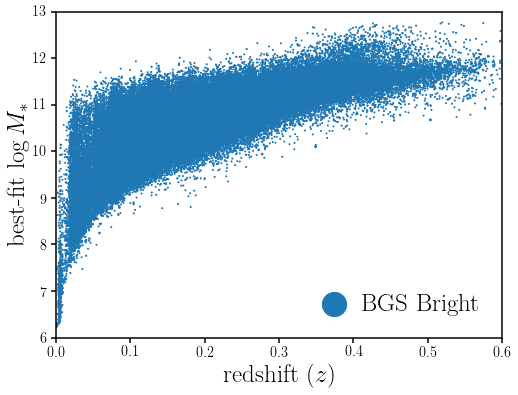

In [11]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['Z_HP'].data, np.median(bgs['provabgs_logMstar'].data, axis=1), 
            s=bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign'].data, c='C0', label='BGS Bright')
sub.legend(loc='lower right', fontsize=25, markerscale=10, handletextpad=0.1)
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.6)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=25)
sub.set_ylim(6., 13.)

In [12]:
zmins = np.array([0.01 + 0.04 * i for i in range(4)])
zmaxs = np.array([0.05 + 0.04 * i for i in range(4)])

# $p(M_* | \{x_i, z_i \})$ in $z$ bins

In [13]:
class GaussianMixtureModel(nn.Module):
    def __init__(self, n_components: int=2, mmin=7., mmax=13.):
        super().__init__()
        logweights = torch.zeros(n_components, )
        means   = (mmax-mmin)*torch.rand(n_components, ) + mmin
        logstdevs  = 0.1*torch.tensor(np.random.uniform(size=n_components)) - 1.
        
        self.logweights = torch.nn.Parameter(logweights)
        self.means   = torch.nn.Parameter(means)
        self.logstdevs  = torch.nn.Parameter(logstdevs)
    
    def forward(self, x):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return - gmm.log_prob(x).mean()
    
    def log_prob(self, x): 
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.log_prob(x)
    
    def sample(self, N):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        
        return gmm.sample(N)

In [14]:
_zmin, _zmax, mlim = np.loadtxt(os.path.join(dat_dir, 'psmf.logmstar_comp_limit.dat'), unpack=True, usecols=[0, 1, 2])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


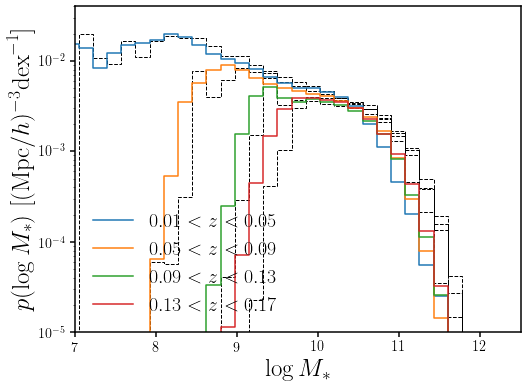

In [15]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    
    #psmf_model = best_models_z[i] 
    psmf_model = torch.load(os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))
    
    # calculate normalization
    _h, _be, _ = sub.hist(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
             weights=w_import[zlim]/np.sum(w_import[zlim]) * norm, 
             range=(6., 13.), bins=40, histtype='step', 
             color='k', linestyle='--', linewidth=1) 
    
    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)
    
    sub.step(be[:-1], h, where='pre', color='C%i' % i, linestyle='-')
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))
    
sub.legend(loc='lower left', fontsize=20)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(7., 12.5)
sub.set_ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e-5, 4e-2)
plt.show()

# jack knife uncertainties

In [16]:
fields = [
    ((bgs['RA'] > 140) & (bgs['RA'] < 160)), 
    ((bgs['RA'] > 160) & (bgs['RA'] < 185) & (bgs['DEC'] > -10) & (bgs['DEC'] < 10)), 
    ((bgs['RA'] > 205) & (bgs['RA'] < 212) & (bgs['DEC'] > 2) & (bgs['DEC'] < 8)), 
    ((bgs['RA'] > 210) & (bgs['RA'] < 224) & (bgs['DEC'] > -5) & (bgs['DEC'] < 5) & ~((bgs['RA'] > 205) & (bgs['RA'] < 212) & (bgs['DEC'] > 2) & (bgs['DEC'] < 8))),
    ((bgs['RA'] > 190) & (bgs['RA'] < 200) & (bgs['DEC'] > 20) & (bgs['DEC'] < 30)), 
    ((bgs['RA'] > 210) & (bgs['RA'] < 225) & (bgs['DEC'] > 30) & (bgs['DEC'] < 40)),     
    ((bgs['RA'] > 250) & (bgs['RA'] < 260) & (bgs['DEC'] > 30) & (bgs['DEC'] < 40)),
    ((bgs['RA'] > 230) & (bgs['RA'] < 255) & (bgs['DEC'] > 40) & (bgs['DEC'] < 45)),    
    ((bgs['RA'] > 210) & (bgs['RA'] < 225) & (bgs['DEC'] > 45) & (bgs['DEC'] < 58)),        
    ((bgs['RA'] > 235) & (bgs['RA'] < 255) & (bgs['DEC'] > 50) & (bgs['DEC'] < 60)), 
    ((bgs['RA'] > 180) & (bgs['RA'] < 200) & (bgs['DEC'] > 55) & (bgs['DEC'] < 70)), 
    ((bgs['RA'] > 260) & (bgs['RA'] < 280) & (bgs['DEC'] > 55) & (bgs['DEC'] < 70))    
]

A_fields = [164.965, 156.064, 164.917, 138.785, 155.972, 164.848, 165.120, 148.024, 
            165.015, 165.030, 164.890, 156.806]

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


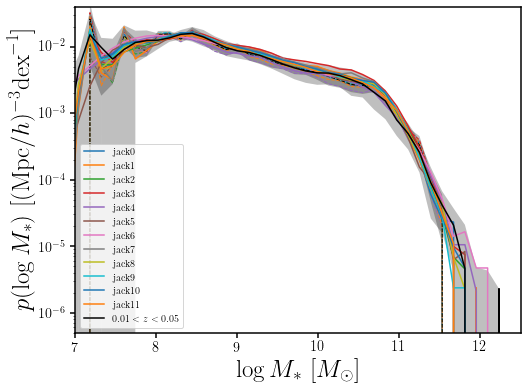

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


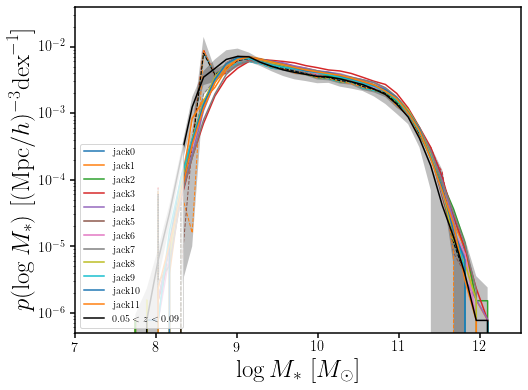

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


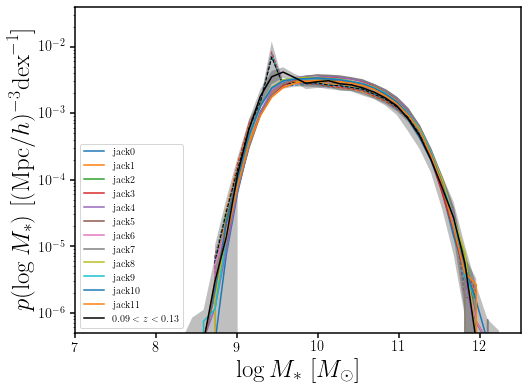

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


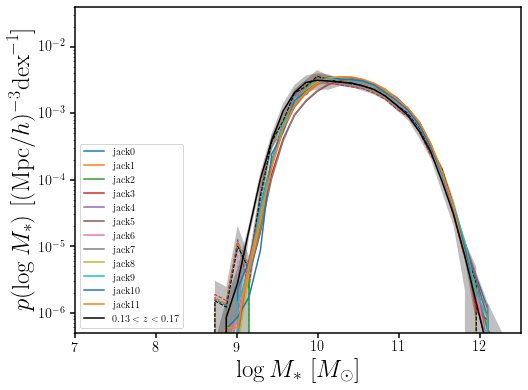

In [18]:
for i, zmin, zmax in zip(range(4), zmins, zmaxs):    
    fig = plt.figure(figsize=(8,6))
    sub = fig.add_subplot(111)
    # calculate normalization
    # Vmax based importance weights
    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign'].data

    h_jack0 = [] 
    for i_jack, field, A_field in zip(range(len(fields)), fields, A_fields): 
        # calculate normalization
        zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & ~field
        norm = np.sum(w_import[zlim]) / ((v_zmax - v_zmin) / f_area * (A_field/(4.*np.pi*(180/np.pi)**2)))

        _h, be = np.histogram(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
                             weights=w_import[zlim], range=(6., 13.), bins=50, density=True) 
        sub.plot(0.5*(be[:-1] + be[1:]), _h*norm*(be[-1] - be[0])/(len(be)-1), color='C%i' % i_jack, ls='--', lw=1)        
        h_jack0.append(_h*norm*(be[-1] - be[0])/(len(be)-1))
        
    h_jack0 = np.array(h_jack0)
    sig_jack0 = np.sqrt(float(len(fields)-1)/float(len(fields)) * np.sum((h_jack0 - np.mean(h_jack0, axis=0))**2, axis=0))    

    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    _h, _ = np.histogram(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
                             weights=w_import[zlim], range=(be[0], be[-1]), bins=len(be)-1, density=True) 
    sub.plot(0.5*(be[:-1] + be[1:]), _h*norm*(be[-1] - be[0])/(len(be)-1), color='k', ls='--', lw=1)      
    sub.fill_between(0.5*(be[:-1] + be[1:]), 
                     _h*norm*(be[-1] - be[0])/(len(be)-1)-sig_jack0, 
                     _h*norm*(be[-1] - be[0])/(len(be)-1)+sig_jack0,
                     color='k', edgecolor='none', alpha=0.25)
    np.savetxt(os.path.join(dat_dir, 'smf.standard.sv3.%s.z%.2f_%.2f.dat' % (targ, zmin, zmax)),
              np.array([0.5*(be[:-1] + be[1:]), _h*norm*(be[-1] - be[0])/(len(be)-1)]).T, 
              header='log stellar mass completeness limit %.2f' % mlim[2*i+1])

    h_jack = []
    for i_jack, field, A_field in zip(range(len(fields)), fields, A_fields): 
        # calculate normalization
        zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & ~field
        norm = np.sum(w_import[zlim]) / ((v_zmax - v_zmin) / f_area * (A_field/(4.*np.pi*(180/np.pi)**2)))

        fgmm = os.path.join(dat_dir, 'psmf.gmm.%s.z%.2f_%.2f.jack%i.pt' % (targ, zmin, zmax, i_jack))
        psmf_model = torch.load(fgmm, map_location=device)
        with torch.no_grad(): 
            post_prime = psmf_model.sample((100000,))
        _h, _ = np.histogram(np.array(post_prime.detach().cpu()), 
                             weights=np.repeat(norm, 100000) / 100000, range=(be[0], be[-1]), bins=len(be)-1)
        sub.plot(0.5*(be[:-1] + be[1:]), _h, color='C%i' % i_jack, ls='-', label='jack%i' % i_jack)
        h_jack.append(_h)
    h_jack = np.array(h_jack)
    sig_jack = np.sqrt(float(len(fields)-1)/float(len(fields)) * np.sum((h_jack - np.mean(h_jack, axis=0))**2, axis=0))
    
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)
    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    psmf_model = torch.load(os.path.join(dat_dir, 'psmf.gmm.%s.z%.2f_%.2f.pt' % (targ, zmin, zmax)), 
                            map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))
    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=50)
    #sub.fill_between(0.5*(be[:-1] + be[1:]), h-sig_jack0, h+sig_jack0, color='k', edgecolor='none', alpha=0.25)
    sub.plot(0.5*(be[:-1] + be[1:]), h, color='k')
    sub.fill_between(0.5*(be[:-1] + be[1:]), h-sig_jack, h+sig_jack, color='k', edgecolor='none', alpha=0.25)
    sub.plot([], [], c='k', label='$%.2f < z < %.2f$' % (zmin, zmax))
    
    np.savetxt(os.path.join(dat_dir, 'psmf.sv3.%s.z%.2f_%.2f.dat' % (targ, zmin, zmax)),
              np.array([0.5*(be[:-1] + be[1:]), h, sig_jack]).T, 
              header='log stellar mass completeness limit %.2f' % mlim[2*i+1])

    sub.legend(loc='lower left', fontsize=10, markerscale=5, frameon=True)
    sub.set_xlabel(r'$\log M_*$  [$M_\odot$]', fontsize=25)
    sub.set_xlim(7., 12.5)
    sub.set_ylabel(r'$p(\log M_*)$  [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=25)
    sub.set_yscale('log')
    sub.set_ylim(5e-7, 4e-2)
    plt.show()
